In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial.distance as sp_dist

In [2]:
DIR = "data/"

In [3]:
# Manhattan distance
d  = lambda p1, p2: np.linalg.norm(p1 - p2, ord=1) # Compare two points
dv = lambda v1, v2: np.sum(np.abs(v1-v2), axis=1) #  Elementwise distance
dM = lambda v1, v2: sp_dist.cdist(v1, v2, metric='cityblock') # Distance matrix 

In [4]:
def loadRequest(request):
    data = []
    file = open(request)
    for line in file:
        data.append(list(map(int, line.strip().replace("-", " ").split())))
    file.close()
    return np.array(data)

In [5]:
def plotPositions(manana, tarde, noche):
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True, figsize=(16, 5))
    ax1.scatter(manana[:,0], manana[:,1], c='y')
    ax2.scatter(tarde[:,0], tarde[:,1], c='r')
    ax3.scatter(noche[:,0], noche[:,1], c='k')
    ax1.set_title("Mañana")
    ax2.set_title("Tarde")
    ax3.set_title("Noche")
    plt.show()

In [21]:
def plotCosts(greedy, random, harmonic, title=""):
    plt.figure(figsize=(10, 8))
    plt.title(title)
    plt.plot(np.arange(len(greedy)), greedy, label="Greedy")
    plt.plot(np.arange(len(random)), random, label="Random")
    plt.plot(np.arange(len(harmonic)), harmonic, label="Harmonic")
    plt.xlabel("Time")
    plt.ylabel("Cost")
    plt.legend()
    plt.grid(True)
    plt.show()

In [7]:
# Load positions
manana = np.loadtxt(DIR + 'manana.dat', dtype=int)
tarde = np.loadtxt(DIR + 'tarde.dat', dtype=int)
noche = np.loadtxt(DIR + 'noche.dat', dtype=int)

In [8]:
# Load requests
req_1 = loadRequest(DIR + 'requests_1.dat')
req_2 = loadRequest(DIR + 'requests_2.dat')
req_3 = loadRequest(DIR + 'requests_3.dat')

In [78]:
def greedyFunc(cand, req):
    dist = dM(cand, req) # Distance matrix between ubers and requests (table 1)
    min_pos = np.argmin(dist, axis=0) # Get position of ubers with min distance to requests
    dist = np.diag(dist[min_pos]) # Distance values 
    return dist, min_pos

In [82]:
def randomFunc(cand, req):
    # Get random ubers for requests
    if len(req) > len(cand): # If there are more requests than candidates
        rand_pos = np.random.choice(len(cand), len(cand), replace=False)
    else:
        rand_pos = np.random.choice(len(cand), len(req), replace=False)
    dist = dv(cand[rand_pos], req) # Compute distance between selected ubers and requests
    return dist, rand_pos

In [86]:
def harmonicFunc(cand, req):
    dist = dM(req, cand) # Distance matrix between ubers and requests 

    # Compute weights
    M = 1/dist 
    n = 1/np.sum(M, axis=1)
    nr = np.repeat(n.reshape(-1,1), len(cand), axis=1)
    w = M*nr # weigths 
    
    # Select ubers using weights 
    har_pos = []
    for i in range(len(req)):
        rand_ = np.random.choice(len(cand), 1, p=w[i])[0]
        while rand_ in har_pos:
            rand_ = np.random.choice(len(cand), 1, p=w[i])[0]
        har_pos.append(rand_)

    # Compute distance between selected ubers and requests
    dist = dv(cand[har_pos], req)
    return dist, har_pos

In [73]:
def base(uber, request, func):
    T = 12001
    cand = np.copy(uber) # Candidates
    request = np.copy(request) # Requests
    costs = np.zeros(T) # Array to save costs
    serv = [] # Ubers in service
    atte_cost = 0 # Cost to get request
    serv_cost = 0 # Cost to complete the request
    for t in range(T): # Time window
        pos = np.where(request[:,4] == t)[0] # Get position of requests at time t
        req_t = request[pos,:4] # Copy initial and final positinos of requests at time t
        
        # If there are requests and candidates 
        if len(req_t) > 0 and len(cand) > 0: 
            
            
            dist, pos = func(cand, req_t[:,:2])
            
            # Get position of ubers with min distance to requests
            #min_pos = np.argmin(dist, axis=0)
            
            # Remove uber from candidates
            cand = np.delete(cand, pos, axis=0) 
            
            # Compute cost 
            atte_cost = dist.reshape(-1, 1)#np.diag(dist[min_pos]).reshape(-1, 1) # Go to request position
            serv_cost = dv(req_t[:,:2], req_t[:,2:4]).reshape(-1, 1) # Go from initial to final position cost
            
            # Create array with [x_f, y_f, cost] for the uber in service
            tmp = req_t[:,2:4] # The new position of uber at end of service
            tmp = np.hstack((tmp, atte_cost + serv_cost))
 
            # Add uber to service
            if len(serv) == 0: # New serv array
                serv = tmp
            else: # Append if serv exists
                serv = np.vstack((serv, tmp))
        
        # If there are ubers in service
        if len(serv) > 0:
            serv[:,-1] -= 1 # Remove 1 from cost (it simulates the car moving to end request destination)
            pos_serv = np.where(serv[:,2] <= 0)[0] # Get array position of ubers in destination

            if len(serv[pos_serv]) > 0: # If there are ubers that complete the service
                cand = np.vstack((cand, serv[pos_serv, :2])) # Add to candidates array
                serv = np.delete(serv, pos_serv, axis=0) # Remove from ubers in service

        costs[t] = len(serv) + (np.sum(costs[t-1]) if t > 0 else 0)#np.sum(serv[:,-1]) if len(serv) > 0 else 0 # Compute cost

    return costs

In [74]:
def greedy(uber, request):
    return base(uber, request, greedyFunc)

In [83]:
def random(uber, request):
    return base(uber, request, randomFunc)

In [87]:
def harmonic(uber, request):
    return base(uber, request, harmonicFunc)

In [49]:
def greedy(uber, request):
    T = 12001
    cand = np.copy(uber) # Candidates
    request = np.copy(request) # Requests
    costs = np.zeros(T) # Array to save costs
    serv = [] # Ubers in service
    atte_cost = 0 # Cost to get request
    serv_cost = 0 # Cost to complete the request
    for t in range(T): # Time window
        pos = np.where(request[:,4] == t)[0] # Get position of requests at time t
        req_t = request[pos,:4] # Copy initial and final positinos of requests at time t
        
        # If there are requests and candidates 
        if len(req_t) > 0 and len(cand) > 0: 
            # Distance matrix between ubers and requests (table 1)
            dist = dM(cand, req_t[:,:2])
            
            # Get position of ubers with min distance to requests
            min_pos = np.argmin(dist, axis=0)
            
            # Remove uber from candidates
            cand = np.delete(cand, min_pos, axis=0) 
            
            # Compute cost 
            atte_cost = np.diag(dist[min_pos]).reshape(-1, 1) # Go to request position
            serv_cost = dv(req_t[:,:2], req_t[:,2:4]).reshape(-1, 1) # Go from initial to final position cost
            
            # Create array with [x_f, y_f, cost] for the uber in service
            tmp = req_t[:,2:4] # The new position of uber at end of service
            tmp = np.hstack((tmp, atte_cost + serv_cost))
 
            # Add uber to service
            if len(serv) == 0: # New serv array
                serv = tmp
            else: # Append if serv exists
                serv = np.vstack((serv, tmp))
        
        # If there are ubers in service
        if len(serv) > 0:
            serv[:,-1] -= 1 # Remove 1 from cost (it simulates the car moving to end request destination)
            pos_serv = np.where(serv[:,2] <= 0)[0] # Get array position of ubers in destination

            if len(serv[pos_serv]) > 0: # If there are ubers that complete the service
                cand = np.vstack((cand, serv[pos_serv, :2])) # Add to candidates array
                serv = np.delete(serv, pos_serv, axis=0) # Remove from ubers in service

        costs[t] = len(serv) + (np.sum(costs[t-1]) if t > 0 else 0)#np.sum(serv[:,-1]) if len(serv) > 0 else 0 # Compute cost

    return costs

In [50]:
def random(uber, request):
    T = 12001
    cand = np.copy(uber) # Candidates
    request = np.copy(request) # Requests
    costs = np.zeros(T) # Array to save costs
    serv = [] # Ubers in service
    atte_cost = 0 # Cost to get request
    serv_cost = 0 # Cost to complete the request
    for t in range(T): # Time window
        pos = np.where(request[:,4] == t)[0] # Get position of requests at time t
        req_t = request[pos,:4] # Copy initial and final positinos of requests at time t
        
        # If there are requests and candidates 
        if len(req_t) > 0 and len(cand) > 0: 
            # Distance matrix between ubers and requests (table 1)
            #dist = dM(cand, req_t[:,:2])
            
            # Get random ubers for requests
            if len(req_t) > len(cand): # If there are more requests than candidates
                rand_pos = np.random.choice(len(cand), len(cand), replace=False)
            else:
                rand_pos = np.random.choice(len(cand), len(req_t), replace=False)
            
            # Compute distance between selected ubers and requests
            dist = dv(cand[rand_pos], req_t[:,:2])
            
            # Remove uber from candidates
            cand = np.delete(cand, rand_pos, axis=0) 
            
            # Compute cost 
            atte_cost = dist.reshape(-1, 1)#dist[min_pos].reshape(-1, 1) # Go to request position
            serv_cost = dv(req_t[:,:2], req_t[:,2:4]).reshape(-1, 1) # Go from initial to final position cost
            
            # Create array with [x_f, y_f, cost] for the uber in service
            tmp = req_t[:,2:4] # The new position of uber at end of service
            tmp = np.hstack((tmp, atte_cost + serv_cost))
 
            # Add uber to service
            if len(serv) == 0: # New serv array
                serv = tmp
            else: # Append if serv exists
                serv = np.vstack((serv, tmp))
        
        # If there are ubers in service
        if len(serv) > 0:
            serv[:,-1] -= 1 # Remove 1 from cost (it simulates the car moving to end request destination)
            pos_serv = np.where(serv[:,2] <= 0)[0] # Get array position of ubers in destination

            if len(serv[pos_serv]) > 0: # If there are ubers that complete the service
                cand = np.vstack((cand, serv[pos_serv, :2])) # Add to candidates array
                serv = np.delete(serv, pos_serv, axis=0) # Remove from ubers in service
        
        costs[t] = len(serv) + (np.sum(costs[t-1]) if t > 0 else 0) #np.sum(serv[:,-1]) if len(serv) > 0 else 0 # Compute cost

    return costs

In [51]:
def harmonic(uber, request):
    T = 12001
    cand = np.copy(uber) # Candidates
    request = np.copy(request) # Requests
    costs = np.zeros(T) # Array to save costs
    serv = [] # Ubers in service
    atte_cost = 0 # Cost to get request
    serv_cost = 0 # Cost to complete the request
    for t in range(T): # Time window
        pos = np.where(request[:,4] == t)[0] # Get position of requests at time t
        req_t = request[pos,:4] # Copy initial and final positinos of requests at time t
        
        # If there are requests and candidates 
        if len(req_t) > 0 and len(cand) > 0: 
            # Distance matrix between ubers and requests (table 1)
            dist = dM(req_t[:,:2], cand)
            
            M = 1/dist#dM(req[:,:2], cand)
            n = 1/np.sum(M, axis=1)
            nr = np.repeat(n.reshape(-1,1), len(cand), axis=1)
            w = M*nr # weigths
            
            har_pos = []
            # Select ubers using weights 
            for i in range(len(req_t)):
                rand_ = np.random.choice(len(cand), 1, p=w[i])[0]
                while rand_ in har_pos:
                    rand_ = np.random.choice(len(cand), 1, p=w[i])[0]
                har_pos.append(rand_)
                    
            # Compute distance between selected ubers and requests
            dist = dv(cand[har_pos], req_t[:,:2])
            
            # Remove uber from candidates
            cand = np.delete(cand, har_pos, axis=0) 
            
            # Compute cost 
            atte_cost = dist.reshape(-1, 1) # Go to request position
            serv_cost = dv(req_t[:,:2], req_t[:,2:4]).reshape(-1, 1) # Go from initial to final position cost
            
            # Create array with [x_f, y_f, cost] for the uber in service
            tmp = req_t[:,2:4] # The new position of uber at end of service
            tmp = np.hstack((tmp, atte_cost + serv_cost))
 
            # Add uber to service
            if len(serv) == 0: # New serv array
                serv = tmp
            else: # Append if serv exists
                serv = np.vstack((serv, tmp))
        
        # If there are ubers in service
        if len(serv) > 0:
            serv[:,-1] -= 1 # Remove 1 from cost (it simulates the car moving to end request destination)
            pos_serv = np.where(serv[:,2] <= 0)[0] # Get array position of ubers in destination

            if len(serv[pos_serv]) > 0: # If there are ubers that complete the service
                cand = np.vstack((cand, serv[pos_serv, :2])) # Add to candidates array
                serv = np.delete(serv, pos_serv, axis=0) # Remove from ubers in service
        
        costs[t] = len(serv) + (np.sum(costs[t-1]) if t > 0 else 0) #np.sum(serv[:,-1]) if len(serv) > 0 else 0 # Compute cost

    return costs

## Ubers positions at $t=0$

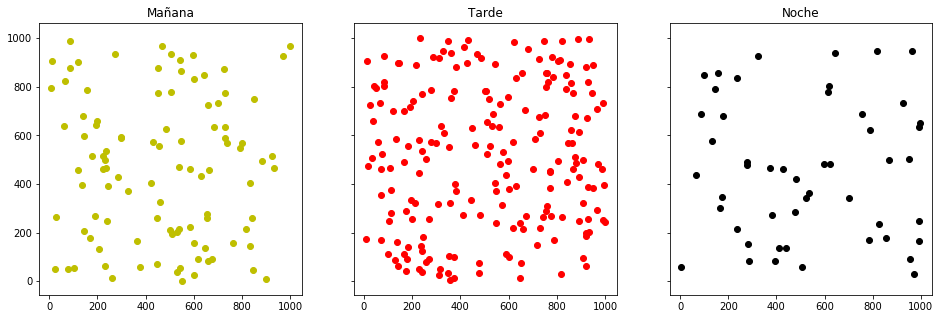

In [12]:
plotPositions(manana, tarde, noche)

In [76]:
costs_greedy = greedy(manana, req_1)

In [84]:
costs_random = random(manana, req_1)

In [88]:
costs_harmonic = harmonic(manana, req_1)

In [77]:
costs_greedy[:20]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  2.,  3.,  4.,
        5.,  7.,  9., 11., 13., 15., 17.])

In [55]:
costs_greedy[:20]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  2.,  3.,  4.,
        5.,  7.,  9., 11., 13., 15., 17.])

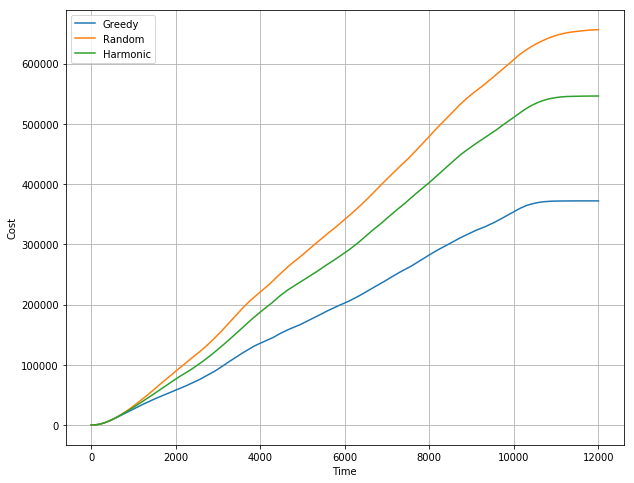

In [85]:
plotCosts(costs_greedy, costs_random, costs_harmonic)

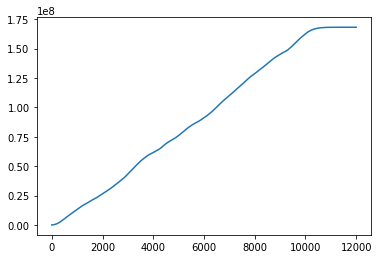

In [180]:
plt.plot(np.cumsum(costs_greedy))